***
**Introduction to Machine Learning** <br>
__[https://slds-lmu.github.io/i2ml/](https://slds-lmu.github.io/i2ml/)__
***

# The scikit-learn package

**scikit-learn** is a widely-used open-source machine learning library in Python, known for its simplicity, efficiency, and accessibility. <br>
It provides a range of supervised and unsupervised learning algorithms, including classification, regression, clustering, and dimensionality reduction. <br>
The library also offers tools for model selection, preprocessing, and evaluation. Its consistent and easy-to-use API makes it a popular choice for both beginners and experienced practitioners in data science and machine learning. <br>
Scikit-learn's integration with other Python libraries like **NumPy** and **Pandas** enhances its functionality and ease of use in data manipulation and analysis.

Go to their website for documentation, version information and useful code examples: https://scikit-learn.org/stable/index.html

### Machine learning algorithims

This notebook will cover every step of the following two algorithms:
* Regression (OLS)
* KNN Classification

## 1. Load the data

We are uing the penguin.csv data set which contains information about 3 penguin species. You can find the dataset on kaggle at [Kaggle - Palmer Archipelago (Antarctica) penguin data](https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data?resource=download).

Once you downloaded the data to your local computer you can start investigating it.

In [148]:
import warnings
warnings.filterwarnings('ignore')

# packages we know and love
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# SciKit Learn packages
from sklearn.model_selection import train_test_split # for splitting data
from sklearn.preprocessing import StandardScaler     # feature scaling
from sklearn import metrics                          # for evaluation metrics

from sklearn.linear_model import LinearRegression    # linear regression
from sklearn.neighbors import KNeighborsClassifier   # knn
from sklearn.cluster import KMeans                   # kmeans

In [91]:
penguins = pd.read_csv('../exercises/data/penguins_size.csv')

In [92]:
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


We see the data set as a categorical column with the species names. There are also some NA values in the data set. for simplicity we will just disregard them.

In [93]:
penguins.dropna(inplace=True)
penguins.reset_index(inplace=True, drop=True)

In [94]:
penguins['species'].value_counts()

species
Adelie       146
Gentoo       120
Chinstrap     68
Name: count, dtype: int64

## 2. Regression (OLS) in scikit-learn

For our regression example, we will subset our data to focus on a single species (Gentoo)

In [95]:
# note: here I am using .reset_index() so that the index values of our subset start at 0
# otherwise would start ~150 - the index of the first Gentoo in the orig dataset
gentoo = penguins[penguins['species']=='Gentoo'][['culmen_length_mm', 'flipper_length_mm']].copy()
gentoo.dropna(inplace=True)
gentoo.reset_index(inplace=True, drop=True)

In [97]:
gentoo.describe()

,culmen_length_mm,flipper_length_mm
count,120.000000,120.000000
mean,47.542500,217.233333
std,3.105692,6.557738
min,40.900000,203.000000
25%,45.300000,212.000000
50%,47.350000,216.000000
75%,49.600000,221.250000
max,59.600000,231.000000


In [98]:
# split the data so have unseen data for evaluation
X_train, X_test, y_train, y_test = train_test_split(gentoo['culmen_length_mm'],   # X
                                                    gentoo['flipper_length_mm'],  # y
                                                    test_size = 0.2,
                                                    random_state=42) 

In [99]:
# train a linear regression on full subset (no test/train split for this example)  
gentoo_lm = LinearRegression()

gentoo_lm.fit(X=X_train.to_frame(), y=y_train)  

LinearRegression()

In [100]:
print('Intercept', gentoo_lm.intercept_)
print('Coefficient', gentoo_lm.coef_) 

Intercept 152.2399743602625
Coefficient [1.36185522]


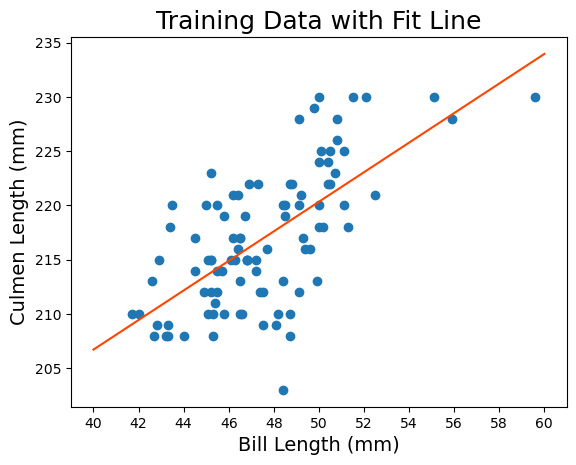

In [101]:
# plot training data with fit line
x_fit = np.arange(40,61, 1) # x values to calculate y values for
y_fit = [(x_i*gentoo_lm.coef_[0]) + gentoo_lm.intercept_ for x_i in x_fit]

plt.scatter(X_train, y_train)
plt.plot(x_fit, y_fit, color='orangered')

plt.xlabel('Bill Length (mm)', size=14)
plt.ylabel('Culmen Length (mm)', size=14)
plt.title('Training Data with Fit Line', size=18)

plt.xticks(np.arange(40, 61, 2)) # set x-ticks
plt.show()

In [102]:
y_pred = gentoo_lm.predict(X_test.to_frame())  

In [103]:
pred_df = pd.DataFrame({'x_test': X_test, 
                        'y_predicted': y_pred,
                        'y_test':y_test}).sort_index()
pred_df.head()

,x_test,y_predicted,y_test
0,46.1,215.021500,211.0
4,47.6,217.064283,215.0
10,40.9,207.939853,214.0
11,49.0,218.970880,216.0
18,46.2,215.157685,209.0


In [104]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 4.875807327668274
Mean Squared Error: 30.846319687630423
Root Mean Squared Error: 5.553946316596013
R-squared 0.42185734283238574


## 3. k-NN classification

KNN is an algorithm that classifies unlabeled observations using the known labels of that observations $k$ nearest neighbors. We'll run this algorithm using SKLearn. You can find the documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

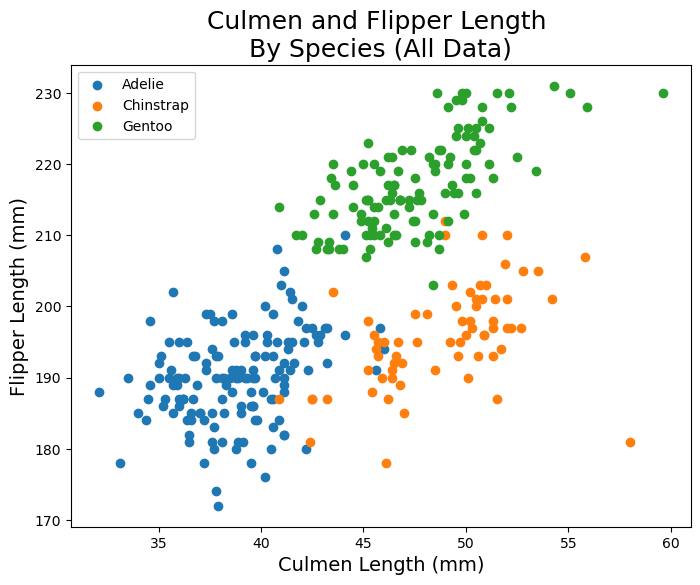

In [105]:
# set shapes and colors of our plot
plt.figure(figsize=(8,6))

# plot each species seperately so they each get their own color
for species in penguins['species'].unique():
    sub = penguins[penguins['species']==species] # subset to a single species
    
    plt.scatter(sub['culmen_length_mm'], sub['flipper_length_mm'],
               label=species)

# labels
plt.xlabel('Culmen Length (mm)', size=14)
plt.ylabel('Flipper Length (mm)', size=14)

plt.title('Culmen and Flipper Length \nBy Species (All Data)',size=18)
plt.legend()

plt.show()

In [106]:
# create X dataframe with our IVs
X = penguins[['culmen_length_mm', 
             'culmen_depth_mm',
             'flipper_length_mm', 
             'body_mass_g']]

# create vector of y variable (label) 
Y = penguins['species']

In [107]:
# rescale IVs as k-NN is a distance based Algorithmn
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X) 

In [108]:
# display mean and standard deviation of original input data
print('Means of IVs:', scaler.mean_)
print('Variance of IVs:', scaler.var_)

Means of IVs: [  43.99431138   17.16047904  201.01497006 4209.05688623]
Variance of IVs: [2.97280215e+01 3.86107282e+00 1.96032710e+02 6.45821790e+05]


In [109]:
# put our scaled data in to a dataframe
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# by definition, our rescaled data has a mean of 0 and and SD of 1
for column in df_scaled:
    print(column)
    print('   Mean: {:.2f}'.format(np.mean(df_scaled[column])))
    print('   SD: {:.2f}'.format(np.std(df_scaled[column])))

culmen_length_mm
   Mean: -0.00
   SD: 1.00
culmen_depth_mm
   Mean: -0.00
   SD: 1.00
flipper_length_mm
   Mean: 0.00
   SD: 1.00
body_mass_g
   Mean: -0.00
   SD: 1.00


In [123]:
# split data 80% training
# we can use the exact same code that we did when splitting the data for our regression
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.20, random_state=100)  

In [124]:
# train our classifier
classifier = KNeighborsClassifier().fit(X_train, y_train) # default to n_neighbors = 5

In [125]:
y_pred = classifier.predict(X_test)    # make predictions on our test data

In [126]:
df_eval = pd.DataFrame({'Actual': y_test,
                        'Predicted': y_pred})

df_eval.head(10)

,Actual,Predicted
305,Gentoo,Gentoo
177,Chinstrap,Chinstrap
330,Gentoo,Gentoo
46,Adelie,Adelie
289,Gentoo,Gentoo
120,Adelie,Adelie
191,Chinstrap,Chinstrap
154,Chinstrap,Adelie
266,Gentoo,Gentoo
188,Chinstrap,Chinstrap


In [127]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Adelie       0.96      1.00      0.98        27
   Chinstrap       1.00      0.92      0.96        12
      Gentoo       1.00      1.00      1.00        28

    accuracy                           0.99        67
   macro avg       0.99      0.97      0.98        67
weighted avg       0.99      0.99      0.98        67



In [128]:
print(metrics.confusion_matrix(y_test, y_pred))

[[27  0  0]
 [ 1 11  0]
 [ 0  0 28]]
